# Imports

In [0]:
import csv
import io
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import files

# Hyper Parameters


In [0]:
vocab_size = 8000
embedding_dim = 64
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
num_epochs = 20

# Dataset Loading and Preprocessing

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))

train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = to_categorical(np.array(label_tokenizer.texts_to_sequences(train_labels)), num_classes = 6)
validation_label_seq = to_categorical(np.array(label_tokenizer.texts_to_sequences(validation_labels)), num_classes = 6)

print(training_label_seq.shape)
print(validation_label_seq.shape)

--2020-05-06 11:15:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:80e::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2020-05-06 11:15:33 (237 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]

2225
2225
1780
1780
1780
445
445
(1780, 6)
(445, 6)


# Model

In [4]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                             tf.keras.layers.LSTM(64 ,return_state = False),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(6, activation='softmax')
                            ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 64)           512000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 563,206
Trainable params: 563,206
Non-trainable params: 0
_________________________________________________________________


# Training and Validation

In [5]:
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=1)

Epoch 1/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6628 - accuracy: 0.2461 - val_loss: 1.4853 - val_accuracy: 0.2427
Epoch 2/20
56/56 [==============================] - 1s 15ms/step - loss: 1.0535 - accuracy: 0.5781 - val_loss: 0.6360 - val_accuracy: 0.7955
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 0.3957 - accuracy: 0.8708 - val_loss: 0.7135 - val_accuracy: 0.7888
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 0.1764 - accuracy: 0.9534 - val_loss: 0.2235 - val_accuracy: 0.9326
Epoch 5/20
56/56 [==============================] - 1s 15ms/step - loss: 0.0540 - accuracy: 0.9865 - val_loss: 0.3721 - val_accuracy: 0.9011
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 0.0333 - accuracy: 0.9944 - val_loss: 0.2530 - val_accuracy: 0.9258
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 0.0157 - accuracy: 0.9966 - val_loss: 0.2250 - val_accuracy: 0.9393
Epoch 8/20
56

# Accuracy and Loss Plot

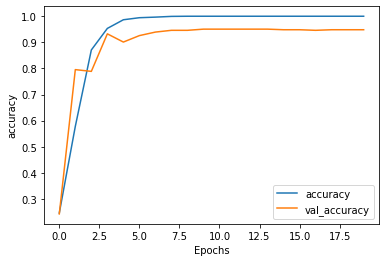

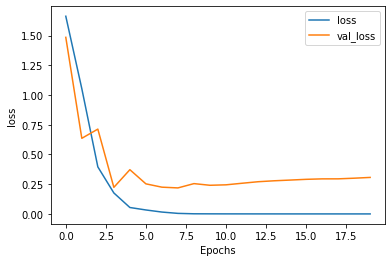

In [7]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Word Embedding Visualisation

In [8]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

files.download('vecs.tsv')
files.download('meta.tsv')

(8000, 64)
